# 冻手实验室3.18-NEU校园卡查询中心模拟登陆与数据获取

## 1.本次将学到

- 如何利用浏览器的开发者功能来了解一个页面
- 用与发送http请求的python库-[requests](http://docs.python-requests.org/zh_CN/latest/user/quickstart.html)
- 用与解析网页的python库-[BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/index.zh.html)

## 2.环境配置

**强烈建议大家提前配置好环境**
- python3
- python包：
    - requests   安装方法：`pip install requests`  
    - BeautifulSoup [安装方法见此处](https://www.crummy.com/software/BeautifulSoup/bs4/doc/index.zh.html#id5)
    - jupyter notebook  [安装方法见此处](http://jupyter.org/install)
    - matplotlib 安装方法：`pip install -U matplotlib`  或者查看[官方教程](https://matplotlib.org/users/installing.html)
- **推荐使用**chrome或者Firefox浏览器


## 3.导入需要用到的包

In [1]:
import requests
from bs4 import BeautifulSoup
import random
import tesserocr
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 4.具体步骤

- 4.1模拟登录
    - 4.1.1获取登陆页面
    - 4.1.2获取验证码
    - 4.1.3登录

- 4.2数据查询与获取
    - 4.2.1 获取查询页面
    - 4.2.2 进行查询
    - 4.2.3 结果翻页





### 4.1.1获取登陆页面

这里，我们先获取尝试利用request来发送get请求登录页面。

为了保持登录的状态，我们需要用到requests的session对象，他可以自动地为我们保存cookies。而一般网站会利用cookies来保存用户的状态。

我们还将使用BeautifulSoup来解析此页面

In [2]:
session = requests.Session()

In [3]:
url_login='http://ecard.neu.edu.cn/SelfSearch/Login.aspx'
resp_login_page = session.get(url=url_login)

In [4]:
#查看获取到网页内容
print(resp_login_page.text)


<!DOCTYPE html PUBLIC "-//W3C//Dtd XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/Dtd/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">
<head id="Head1"><title>
	
        一卡通自助查询
        --欢迎登录
</title><meta http-equiv="Pragma" content="no-cache" /><meta http-equiv="Cache-Control" content="no-cache" /><meta http-equiv="Expires" content="0" /><link href="css/login.css" rel="stylesheet" type="text/css" />
    <style type="text/css">
        .schoolName
        {
            margin-top: 5px;
            width: 320px;
            display: none;
            text-align: center;
            color: Red;
        }
        /* 遮罩层 */
        .overlay { background: #000000; opacity: .50;filter:Alpha(Opacity=50); }

        .overlay-container{position:absolute;z-index:2000;}
        .overlay-loading{background:url(images/loading2.gif) no-repeat center center; width:124px; height:124px; text-align:center; line-height:124px; vertical-align:middle; color:White; font-size

以上内容，我们可以用正则表达式来找出我们想要的信息，不过太难了。让我们来尝尝神奇的BeautifulSoup😎

第一个参数是网页的内容，第二个参数是所用的解析器，‘html.parser’是python标准库中自带的。

这样我们就获得了一个文档对象。

In [5]:
soup_login_page = BeautifulSoup(resp_login_page.text, 'html.parser')

通过这个文档对象可以轻易地获取我们想获取的内容。

以下代码找到了页面中的title标签。

关于find方法的更多介绍，你可以[看这里](https://www.crummy.com/software/BeautifulSoup/bs4/doc/index.zh.html#find)

- find返回第一个结果。
- find_all方法会返回一个储存了全部结果的list

In [6]:
soup_login_page.find('title')

<title>
	
        一卡通自助查询
        --欢迎登录
</title>

也可以直接用id来搜索

In [7]:
soup_login_page.find(id='one1')

<li class="hover" id="one1" onmouseover="setTab('one',1,2)"><a href="#">
                                                用户登录</a> </li>

那你来试试看，获取VIEWSTATE和EVENTVALIDATION的值。

提示：他们的值写的html里面，并且有特定的id。
标签的属性，可以通过`xxx['abc']`来获取

In [8]:
VIEWSTATE= soup_login_page.find(id="__VIEWSTATE")['value']
EVENTVALIDATION= soup_login_page.find(id="__EVENTVALIDATION")['value']
print(VIEWSTATE)
print(EVENTVALIDATION)

/wEPDwUKMTM4OTU1Nzc4NA8WAh4Hc3lzSW5mbzKSBQABAAAA/////wEAAAAAAAAADAIAAABPTmV3Y2FwZWMuVW5pdmVyc2FsU1MuRFRPLCBWZXJzaW9uPTEuMC4wLjAsIEN1bHR1cmU9bmV1dHJhbCwgUHVibGljS2V5VG9rZW49bnVsbAwDAAAAUk5ld2NhcGVjLlVuaXZlcnNhbFNTLkVudGl0eSwgVmVyc2lvbj0xLjAuMC4wLCBDdWx0dXJlPW5ldXRyYWwsIFB1YmxpY0tleVRva2VuPW51bGwFAQAAAChOZXdjYXBlYy5Vbml2ZXJzYWxTUy5EVE8uRFRPX09VVF9TWVNJTkZPBAAAAB48T1BFUkFUSU9OTU9ERT5rX19CYWNraW5nRmllbGQbRFRPX1dTUnVuUmVzdWx0K19yZXN1bHRDb2RlGkRUT19XU1J1blJlc3VsdCtfcmVzdWx0TXNnHURUT19XU1J1blJlc3VsdCtfRWNhcmRWZXJzaW9uBAEBBDNOZXdjYXBlYy5Vbml2ZXJzYWxTUy5FbnRpdHkuRW51bS5FbnVtX09QRVJBVElPTk1PREUDAAAAMk5ld2NhcGVjLlVuaXZlcnNhbFNTLkVudGl0eS5FbnVtLkVudW1fRWNhcmRWZXJzaW9uAwAAAAIAAAAF/P///zNOZXdjYXBlYy5Vbml2ZXJzYWxTUy5FbnRpdHkuRW51bS5FbnVtX09QRVJBVElPTk1PREUBAAAAB3ZhbHVlX18ACAMAAAABAAAABgUAAAABMQYGAAAADOaJp+ihjOaIkOWKnwX5////Mk5ld2NhcGVjLlVuaXZlcnNhbFNTLkVudGl0eS5FbnVtLkVudW1fRWNhcmRWZXJzaW9uAQAAAAd2YWx1ZV9fAAgDAAAAQAAAAAsWAgIDD2QWBAIDDw8WAh4HVmlzaWJsZWhkFgJmDw8WAh4EVGV4dAUIMDAwMDAwMDBkZAILDw8WBB4LTmF2

### 4.1.2获取验证码
通常你看到的网页中的图片，在html中只是写了一个图片的链接。
我们的验证码也需要从一个图片获得。


In [9]:
# 获得验证码的url，你需要写一行,提示：你可能需要随机数函数
url_captcha='http://ecard.neu.edu.cn/SelfSearch/validateimage.ashx?' + str(random.random())
#向该链接发送get请求，并获取Response对象，你需要写一行
resp_captcha = session.get(url=url_captcha)

将图片保存。
[关于二进制的响应内容](http://docs.python-requests.org/zh_CN/latest/user/quickstart.html#id4)

In [10]:
with open('captcha.gif', 'wb') as f:
    f.write(resp_captcha.content)
    f.close()

读取图片文件，并显示。

[教程看这里](https://matplotlib.org/tutorials/introductory/images.html#sphx-glr-tutorials-introductory-images-py)

8050




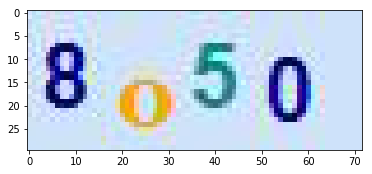

In [11]:
img = mpimg.imread('captcha.gif')
plt.imshow(img)
image = Image.open('captcha.gif')
captcha_code=tesserocr.image_to_text(image)
print(captcha_code)

In [12]:
#把看到的验证码填到这里,注意是字符串形式哟(nope)
captcha=captcha_code

### 4.1.3登录

登录需要向服务器发送一个post请求，
你需要先获取所需的链接和post请求的请求体内容

In [13]:
userName = 20175364
passwd=235956

postdata = {
    "_LASTFOCUS": '',
    "__EVENTTARGET": 'btnLogin',
    "__EVENTARGUMENT":'',
    "__VIEWSTATE":VIEWSTATE,
    "__EVENTVALIDATION":EVENTVALIDATION,
    "txtUserName":userName,
    "txtPassword":passwd,
    "txtVaildateCode":captcha,
    "hfIsManager":0
}
url_login ="http://ecard.neu.edu.cn/SelfSearch/login.aspx"


In [14]:
loginresponse = session.post(url=url_login,data=postdata)
print('跳转的链接：', loginresponse.url)

跳转的链接： http://ecard.neu.edu.cn/SelfSearch/Index.aspx


如果返回的是'http://ecard.neu.edu.cn/SelfSearch/Index.aspx' 则说明我们已经登录成功并且跳转到了登陆后的页面。

来看看你的证件照吧！

In [15]:
# 自己去找照片的url
url_profile_photo='http://ecard.neu.edu.cn/SelfSearch/User/Photo.ashx'

#发送get请求
resp_profile_photo = session.get(url=url_profile_photo)

#你可以看请求对象的url属性值是否为http://ecard.neu.edu.cn/SelfSearch/User/Photo.ashx 来判断是否是登录成功的。因为要是没成功，回跳转到登录页面
print('跳转链接', resp_profile_photo.url)

#保存图片
with open('userPic.jpg', 'wb') as f:
    f.write(resp_profile_photo.content)
    f.close()


跳转链接 http://ecard.neu.edu.cn/SelfSearch/User/Photo.ashx


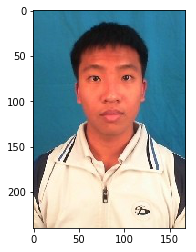

In [16]:
#查看图片，自己写
pic=mpimg.imread('userPic.jpg')
plt.imshow(pic)

### 4.2数据查询与获取

### 4.2.1 获取查询页面

4.2.3 结果翻页

In [21]:
# 自己找消费记录是向哪个url请求的
url_consumeInfo='http://ecard.neu.edu.cn/SelfSearch/User/ConsumeInfo.aspx'

#获取页面
consume_response0=session.get(url_consumeInfo)
consume_soup = BeautifulSoup(consume_response0.text, 'html.parser')

#解析出以下两个变量的值
VIEWSTATE='/wEPDwUINDEyMzA5NDkPFgIeCFNvcnRUeXBlBQNBU0MWAmYPZBYCAgMPZBYCAgMPZBYCAgQPPCsAEQIADxYEHgtfIURhdGFCb3VuZGceC18hSXRlbUNvdW50ZmQBEBYAFgAWABYCZg9kFgJmD2QWAgIBD2QWAgIBDw8WBB4IQ3NzQ2xhc3MFClNvcnRCdF9Bc2MeBF8hU0ICAmRkGAEFImN0bDAwJENvbnRlbnRQbGFjZUhvbGRlcjEkZ3JpZFZpZXcPPCsADAEIZmRqLvyQCIBEvWoXSvjpoBGX5CYVpWemU6R5wXfkXD2GKQ=='
EVENTVALIDATION='/wEWCAKy/LiJCQL4s9G2CQLns9G2CQLo3PvYBQKQz7OvAgK0zsCfBwL3uvOGAgLk75bKAoTuITueqPrQRS8Lzt4XoYl/ko91ofQH1FUegaVurgQU'

### 4.2.2 进行查询与数据解析

In [22]:
#构造postdata
postdata_consume = {
    "__EVENTTARGET":'' ,
    "__EVENTARGUMENT": '',
    "__VIEWSTATE": VIEWSTATE,
    "__EVENTVALIDATION": EVENTVALIDATION,
    "ctl00$ContentPlaceHolder1$rbtnType": '0',
    "ctl00$ContentPlaceHolder1$txtStartDate": '2018-03-13',
    "ctl00$ContentPlaceHolder1$txtEndDate": '2018-03-20',
    "ctl00$ContentPlaceHolder1$btnSearch": '查  询'
}

resp_consume_1=session.post(url_consumeInfo,data=postdata_consume)
soup_consume_1 = BeautifulSoup(resp_consume_1.text, 'html.parser')


ConnectionError: ('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None))

In [19]:
#找到显示交易信息的table
info_table=soup_consume_1.table
print(info_table)

NameError: name 'soup_consume_1' is not defined

In [20]:
#想办法利用find_all方法，把每一行的数据提出来，再把一行中的对应内容提取出来
#提示：对于一个文档对象  可以利用abc.text 来获取其文字内容
#提示：关于HTML的table，可以看这里http://www.w3school.com.cn/tags/tag_table.asp
'''
for td in info_table.find_all(name='td') :
    print(td.string)
'''
print(info_table.find_all(class_="HeaderStyle"))
#for i in info_table:
#    print(i)

NameError: name 'info_table' is not defined

### 4.2.3 翻页（自己完成）

1. 探索翻页实现的机制
2. 构造对应的请求数据实现翻页